# Spectral Graph Theory

[Spectral Graph Theory](https://en.wikipedia.org/wiki/Spectral_graph_theory) studies graphs using associated matrices such as the adjacency matrix and graph Laplacian.  Let $G(V, E)$ be a graph.  We'll let $n = |V|$ denote the number of vertices/nodes, and $m = |E|$ denote the number of edges.  We'll assume that vertices are indexed by $0,\dots,n-1$, and edges are indexed by $0,\dots,m-1$.

The **adjacency matrix** $A$ is a $n\times n$ matrix with $A_{i,j} = 1$ if $(i,j) \in E$ is an edge, and $A_{i,j} = 0$ if $(i,j) \notin E$.  If $G$ is an undirected graph, then $A$ is symmetric.  If $G$ is directed, then $A$ need not be symmetric.

The **degree** of a node $i$, $deg(i)$ is the number of neighbors of $i$, meaning the number of edges which $i$ participates in.  You can calculate the vector of degrees (a vector $d$ of length $n$, where $d_i = deg(i)$), using matrix-vector mulpilication:
\begin{equation}
d = A 1
\end{equation}
where $1$ is the vector containing all 1s of length $n$.  You could also just sum the row entries of $A$.  We will also use $D = diag(d)$ - a diagonal matrix with $D_{i,i} = d_i$.

The **incidence matrix** $B$ is a $n \times m$ matrix which encodes how edges and vertices are related.  Let $e_k = (i,j)$ be an edge.  Then the $k$-th column of $B$ is all zeros except $B_{i,k} = -1$, and $B_{j,k} = +1$ (for undirected graphs, it doesn't matter which of $B_{i,k}$ and $B_{j,k}$ is $+1$ and which is $-1$ as long as they have opposite signs).
Note that $B^T$ acts as a sort of difference operator on functions of vertices, meaning $B^T f$ is a vector of length $m$ which encodes the difference in fuction value over each edge.

You can check that $B^T 1_C = 0$, where $1_C$ is a connected component indicator ($1_C[i] = 1$ if $i \in C$, and $1_C[i] = 0$ otherwise).  $C\subseteq V$ is a connected component of the graph if all vertices in $C$ have a path between them, and there are no vertices in $V$ that are connected to $C$ which are not in $C$.  This implies $B^T 1 = 0$.

The **graph laplacian** $L$ is an $n \times n$ matrix $L = D- A = B B^T$.  If the graph lies on a regular grid, then $L = -\Delta$ up to scaling by a finite difference width $h^2$, but the graph laplacian is defined for all graphs.

Note that the nullspace of $L$ is the same as the nullspace of $B^T$ (the span of indicators on connected components).

In most cases, it makes sense to store all these matrices in sparse format.

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.sparse as sparse
import scipy.sparse.linalg as sla

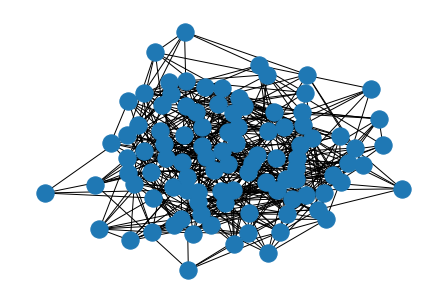

In [2]:
G = nx.gnp_random_graph(100, 0.1)
nx.draw(G)

In [3]:
nx.adj_matrix(G)

/var/folders/6w/3k9kdsgn2mz6rkmvhbzm3snm0000gn/T/ipykernel_6573/138470788.py:1: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  nx.adj_matrix(G)


<100x100 sparse matrix of type '<class 'numpy.int64'>'
	with 1022 stored elements in Compressed Sparse Row format>

In [4]:
nx.incidence_matrix(G)

<100x511 sparse matrix of type '<class 'numpy.float64'>'
	with 1022 stored elements in Compressed Sparse Column format>

In [5]:
nx.laplacian_matrix(G)

<100x100 sparse matrix of type '<class 'numpy.int64'>'
	with 1122 stored elements in Compressed Sparse Row format>

### Exercise

For an undirected graph $G(V, E)$, let $n = |V|$ and $m = |E|$.  Give an expression for the number of non-zeros in each of $A$, $B$, and $L$ in terms of $n$ and $m$.

---

$A$ and $B$ both have $2m$ non-zeros.  $L$ has $n + 2m$ non-zeros.

## Random Walks on Graphs

In a random walk on a graph, we consider an agent who starts at a vertex $i$, and then will chose a random neighbor of $i$ and "walk" along the connecting edge.  Typically, we will consider taking a walk where a neighbor is chosen uniformly at random (i.e. with probability $1/d_i$).  We'll assume that every vertex of the graph has at least one neighbor so $D^{-1}$ makes sense.

This defines a [Markov Chain](https://en.wikipedia.org/wiki/Markov_chain) with transition matrix $P = A D^{-1}$ (columns are scaled to 1).  Note that even if $A$ is symmetric (for undirected graphs) that $P$ need not be symmetric because of the scaling by $D^{-1}$.

The stationary distribution $x$ of the random walk is the top eigenvector of $P$, is guaranteed to have eigenvalue $1$, and is guaranteed to have non-negative entries.  If we scale $x$ so $\|x\|_1 = 1$, The entry $x_i$ can be interpreted as the probability that a random walker which has walked for a very large number of steps is at vertex $i$.

### Page Rank

[PageRank](https://en.wikipedia.org/wiki/PageRank) is an early algorithm that was used to rank websites for search engines.  The internet can be viewed as a directed graph of websites where there is a directed edge $(i, j)$ if webpage $j$ links to webpage $i$.  In this case, we compute the degree vector $d$ using the *out*-degree (counting the number of links out of a webpage).  Then the transition matrix $P = A D^{-1}$ on the directed adjacency matrix defines a random walk on webpages where a user randomly clicks links to get from webpage to webpage.  The idea is that more authoritative websites will have more links to them, so a random web surfer will be more likely to end up with them.

One of the issues with this model is that it is easy for a random walker to get "stuck" at a webpage with no out-going links.  The idea of PageRank is to add a probability $\alpha$ that a web surfer will randomly go to another webpage which is not linked to by their current page.  In this case, we can write the transition matrix
\begin{equation}
P = (1-\alpha) A D^{-1} + \frac{\alpha}{n} 11^T
\end{equation}
We then calculate the stationary vector $x$ of this matrix.  Websites with a larger entry in $x_i$ are deemed more authoritative.

Note that because $A$ is sparse, you'll typically want to encode $\frac{1}{n}11^T$ as a linear operator (this takes the average of a vector, and broadcasts it to the appropriate shape).  For internet-sized graphs this is a necessity.

Let's look at the [Les Miserables graph](https://networkx.org/documentation/stable/reference/generated/networkx.generators.social.les_miserables_graph.html#networkx.generators.social.les_miserables_graph), which encodes interactions between characters in the novel [Les Miserables](https://en.wikipedia.org/wiki/Les_Mis%C3%A9rables) by Victor Hugo.

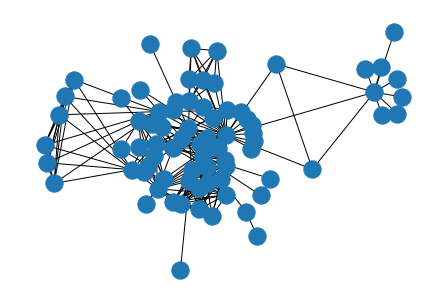

In [4]:
G = nx.les_miserables_graph()
nx.draw_kamada_kawai(G)

In [5]:
G.nodes(data=True)

NodeDataView({'Napoleon': {}, 'Myriel': {}, 'MlleBaptistine': {}, 'MmeMagloire': {}, 'CountessDeLo': {}, 'Geborand': {}, 'Champtercier': {}, 'Cravatte': {}, 'Count': {}, 'OldMan': {}, 'Valjean': {}, 'Labarre': {}, 'Marguerite': {}, 'MmeDeR': {}, 'Isabeau': {}, 'Gervais': {}, 'Listolier': {}, 'Tholomyes': {}, 'Fameuil': {}, 'Blacheville': {}, 'Favourite': {}, 'Dahlia': {}, 'Zephine': {}, 'Fantine': {}, 'MmeThenardier': {}, 'Thenardier': {}, 'Cosette': {}, 'Javert': {}, 'Fauchelevent': {}, 'Bamatabois': {}, 'Perpetue': {}, 'Simplice': {}, 'Scaufflaire': {}, 'Woman1': {}, 'Judge': {}, 'Champmathieu': {}, 'Brevet': {}, 'Chenildieu': {}, 'Cochepaille': {}, 'Pontmercy': {}, 'Boulatruelle': {}, 'Eponine': {}, 'Anzelma': {}, 'Woman2': {}, 'MotherInnocent': {}, 'Gribier': {}, 'MmeBurgon': {}, 'Jondrette': {}, 'Gavroche': {}, 'Gillenormand': {}, 'Magnon': {}, 'MlleGillenormand': {}, 'MmePontmercy': {}, 'MlleVaubois': {}, 'LtGillenormand': {}, 'Marius': {}, 'BaronessT': {}, 'Mabeuf': {}, 'Enjolra

In [6]:
A = nx.adjacency_matrix(G)
A

<77x77 sparse matrix of type '<class 'numpy.int64'>'
	with 508 stored elements in Compressed Sparse Row format>

In [7]:
n = A.shape[0]
d = A.sum(axis=1).reshape(1,-1) # compute degrees
Dinv = sparse.dia_matrix((1 / d, 0), shape=(n, n))
Dinv

<77x77 sparse matrix of type '<class 'numpy.float64'>'
	with 77 stored elements (1 diagonals) in DIAgonal format>

In [8]:
# works on square matrices or vectors
Onefun = lambda X : np.mean(X, axis=0).reshape(1,-1).repeat(X.shape[0], axis=0)

m = A.shape[0] # linear operator of shape of Adjacency matrix

OneOneT = sla.LinearOperator(
    shape   = (m,m),
    matvec  = Onefun,
    rmatvec = Onefun,
    matmat  = Onefun,
    rmatmat = Onefun,
    dtype=np.float   
)


/var/folders/6w/3k9kdsgn2mz6rkmvhbzm3snm0000gn/T/ipykernel_8854/4251835454.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.float


Let's now construct the PageRank matrix and compute the top eigenpairs

In [9]:
alpha = 0.1

P = (1 - alpha) * sla.aslinearoperator(A @ Dinv) + alpha * OneOneT

lam, V = sla.eigs(P, k=2, which='LM')
lam

array([1.        +0.j, 0.83936036+0.j])

In [10]:
x = np.abs(np.real(V[:,0])) # PageRank Vector
x

array([0.0133386 , 0.20399851, 0.0949893 , 0.10668613, 0.0133386 ,
       0.0133386 , 0.0133386 , 0.0133386 , 0.01926114, 0.0133386 ,
       0.57767244, 0.0107066 , 0.01679025, 0.0107066 , 0.0107066 ,
       0.0107066 , 0.07701289, 0.08277018, 0.07701289, 0.07992839,
       0.08300515, 0.08007966, 0.07716337, 0.15885074, 0.11720935,
       0.20909641, 0.22214954, 0.1583424 , 0.06719718, 0.04831427,
       0.01895798, 0.0377782 , 0.0107066 , 0.01702923, 0.06181196,
       0.06181196, 0.05030959, 0.05030959, 0.05030959, 0.02101082,
       0.01050109, 0.06584516, 0.02292668, 0.02325998, 0.02366606,
       0.0160557 , 0.02666986, 0.01541702, 0.1673304 , 0.104165  ,
       0.01375137, 0.09145499, 0.01729798, 0.01099474, 0.02347196,
       0.31496208, 0.0133744 , 0.05356893, 0.23233548, 0.16932592,
       0.05145195, 0.09653403, 0.21000629, 0.10143451, 0.16574335,
       0.1099175 , 0.04528474, 0.01645582, 0.08526568, 0.09150015,
       0.06900207, 0.04435378, 0.01961912, 0.02781421, 0.02781

In [11]:
i = np.argmax(x)
names = np.array([k for k, _ in G.nodes(data=True)])
names[i]

'Valjean'

In [12]:
perm = np.argsort(x)[::-1] # reverse sort
names[perm[:4]]

array(['Valjean', 'Marius', 'Enjolras', 'Cosette'], dtype='<U16')

## The Graph Laplacian

### Spectral Embeddings

Spectral embeddings are one way of obtaining locations of vertices of a graph for visualization.  One way is to pretend that all edges are Hooke's law springs, and to minimize the potential energy of a configuration of vertex locations subject to the constraint that we can't have all points in the same location.

In one dimension:
\begin{equation}
\mathop{\mathsf{minimize}}_x \sum_{(i,j) \in E} (x_i - x_j)^2\\
\text{subject to } x^T 1 = 0, \|x\|_2 = 1
\end{equation}

Note that the objective function is a quadratic form on the embedding vector $x$:
\begin{equation}
\sum_{(i,j)\in E} (x_i - x_j)^2 = x^T B B^T x = x^T L x
\end{equation}

Because the vector $1$ is in the nullspace of $L$, this is equivalent to finding the eigenvector with *second-smallest* eigenvalue.

For a higher-dimensional embedding, we can use the eigenvectors for the next-largest eigenvalues.

# Attention: the first formula is not shown in the current notebook!

In [19]:
G = nx.grid_2d_graph(10,10)
L = nx.laplacian_matrix(G)
L = sparse.csr_matrix(L, dtype=np.float64)

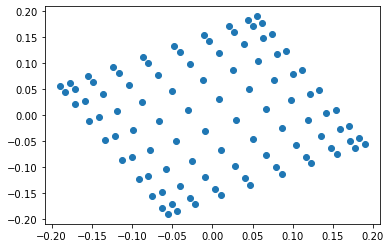

In [20]:
lam, V = sla.eigsh(L, which='SM')
plt.scatter(V[:,1], V[:,2])
plt.show()

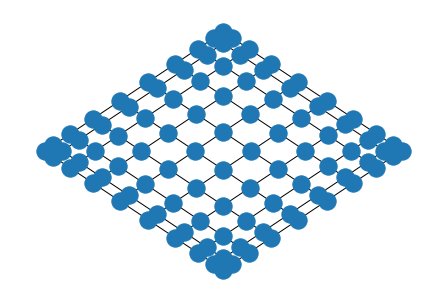

In [21]:
nx.draw_spectral(G)

### Spectral Clustering

Spectral clustering refers to using a spectral embedding to cluster nodes in a graph.  Let $A, B \subset V$ with $A \cap B = \emptyset$.  We will denote
\begin{equation}
E(A, B) = \{(i,j) \in E \mid i\in A, j\in B\}
\end{equation}

One way to try to find clusters is to attempt to find a set of nodes $S \subset V$ with $\bar{S} = V \setminus S$, so that we minimize the cut objective
\begin{equation}
C(S) = \frac{|E(S, \bar{S})|}{\min \{|S|, |\bar{S}|\}}
\end{equation}

The [Cheeger inequality](https://en.wikipedia.org/wiki/Cheeger_constant_(graph_theory)#Cheeger_Inequalities) bounds the second-smallest eigenvalue of $L$ in terms of the optimal value of $C(S)$.  In fact, the way to construct a partition of the graph which is close to the optimal clustering minimizing $C(S)$ is to look at the eigenvector $x$ associated with the second smallest eigenvalue, and let $S = \{i \in V \mid x_i < 0\}$.

As an example, let's look at a graph generated by a stochastic block model with two clusters.  The "ground-truth" clusters are the ground-truth communities in the model.

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


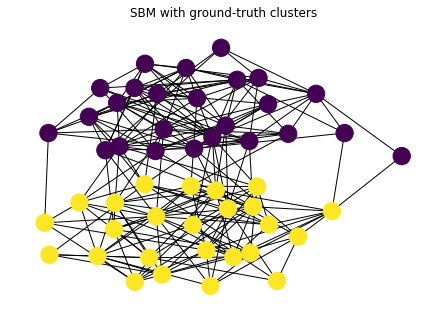

In [37]:
ns = [25, 25] # size of clusters
ps = [[0.3, 0.05], [0.05, 0.3]] # probability of edge
G = nx.stochastic_block_model(ns, ps)
true_clusters = [c for _, c in nx.get_node_attributes(G, 'block').items()]
print(true_clusters)
nx.draw_kamada_kawai(G, with_labels=False, node_color=true_clusters)
plt.title("SBM with ground-truth clusters")
plt.show()

Now, let's use spectral clustering to partition into two clusters

/var/folders/6w/3k9kdsgn2mz6rkmvhbzm3snm0000gn/T/ipykernel_6573/1519315670.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lam, V = sla.eigsh(nx.laplacian_matrix(G).astype(np.float), which='SM')


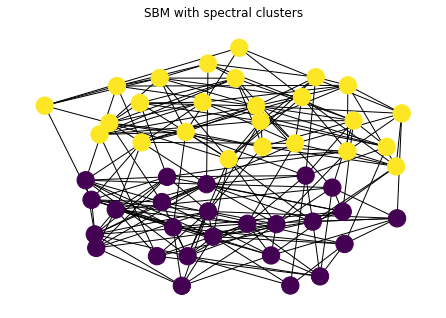

In [15]:
lam, V = sla.eigsh(nx.laplacian_matrix(G).astype(np.float), which='SM')
x = V[:,1]
cs = x < 0 # get clusters

nx.draw_kamada_kawai(G, with_labels=False, node_color=cs)
plt.title("SBM with spectral clusters")
plt.show()

We'll use the [adjusted rand index](https://scikit-learn.org/stable/modules/clustering.html#adjusted-rand-index) to measure the quality of the clustering we obtained.  A value of 1 means that we found the true clusters.

In [38]:
from sklearn import metrics

metrics.adjusted_rand_score(true_clusters, cs)

1.0

In general, you should use a dimension $d$ embedding when looking for $d+1$ clusters (so we used a dimension 1 embedding for 2 clusters).  Let's look at 4 clusters in a SBM

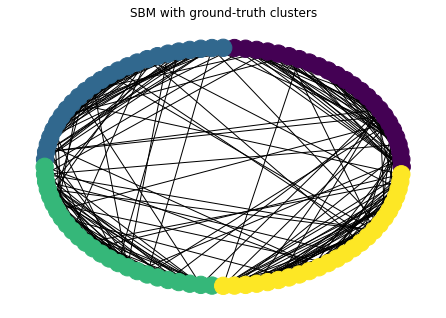

In [42]:
nclusters = 4
ns = [25 for i in range(nclusters)] # size of clusters
ps = 0.02 * np.ones((nclusters, nclusters)) + 0.25 * np.eye(nclusters)
G = nx.stochastic_block_model(ns, ps)
true_clusters = [c for _, c in nx.get_node_attributes(G, 'block').items()]

nx.draw_circular(G, with_labels=False, node_color=true_clusters)
plt.title("SBM with ground-truth clusters")
plt.show()

we'll use K-means clustering in scikit learn to assign clusters.

/var/folders/6w/3k9kdsgn2mz6rkmvhbzm3snm0000gn/T/ipykernel_6573/2627648228.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lam, V = sla.eigsh(nx.laplacian_matrix(G).astype(np.float), k=nclusters, which='SM')


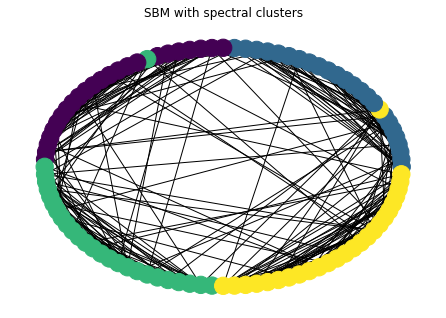

In [49]:
from sklearn.cluster import KMeans

lam, V = sla.eigsh(nx.laplacian_matrix(G).astype(np.float), k=nclusters, which='SM')
X = V#V[:,1:]
cs = KMeans(n_clusters=nclusters).fit_predict(X) # get clusters

nx.draw_circular(G, with_labels=False, node_color=cs)
plt.title("SBM with spectral clusters")
plt.show()

In [50]:
metrics.adjusted_rand_score(true_clusters, cs)

0.9461305260352467

### Exercise

We'll consider the stochastic block model with $k=5$ clusters and $n=25$ nodes per cluster.

Let $p$ be denote the probability of an edge between nodes in the same cluster, and $q$ denote the probability of an edge between nodes in different clusters.

Plot a phase diagram of the adjusted rand index (ARI) score as $p$ and $q$ both vary in the range $[0,1]$. One can let $ p = a\log n/n, q =  p = b\log n/n$, and change $p,q$ via changing $a,b>1$.